## Atomistic Molecular Dynamics: Bulk Liquids - Linear Alkanes

The second system we will consider for performing atomistic MD is a system of linear alkanes.

### Build the system

Again, we will use mBuild to construct our system.

First, we will import mBuild, as well as specify a filter for some warnings that can often clutter the output.

In [ ]:
import mbuild as mb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Now, we will define a class to create a `CH2` moiety, similar to what we did on Monday. Here, we load the structure for a CH2 moeity from a PDB file and add two ports for the two dangling bonds on the carbon.

In [ ]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        mb.load('utils/ch2.pdb', compound=self)
        self.add(mb.Port(anchor=self[0], orientation=[0, 1, 0], separation=0.07), 'up')
        self.add(mb.Port(anchor=self[0], orientation=[0, -1, 0], separation=0.07), 'down')

Let's visualize to make sure it looks okay.

In [ ]:
ch2 = CH2()
ch2.visualize(show_ports=True)

Here, we create a hydrogen atom with a `Port` representing a single dangling bond.

In [ ]:
class Hydrogen(mb.Compound):
    def __init__(self):
        super(Hydrogen, self).__init__()
        self.add(mb.Compound(name='H'))
        self.add(mb.Port(anchor=self[0], orientation=[0, 1, 0], separation=0.07), 'up')

In [ ]:
h = Hydrogen()
h.visualize(show_ports=True)

#### Create class for an alkane chain (with arbitrary length)

Here, we define a class that stitches together CH2 moieties into an alkane chain of a user-defined length (hydrogen atoms are used to cap the ends of the chain to provide the complete chemistry).

In [ ]:
class Alkane(mb.Compound):
    """An alkane chain of a user-defined length."""
    def __init__(self, chain_length):
        """Initialize an Alkane Compound.

        Parameters
        ----------
        chain_length : int
            Length of the alkane chain (in number of carbons)
        """
        # Make sure the user inputs a chain length of at least 1
        if chain_length < 1:
            raise ValueError('Chain length must be greater than 1')
        
        super(Alkane, self).__init__()

        # Create a polymer of CH2 units
        chain = mb.Polymer(CH2(), n=chain_length, port_labels=('up', 'down'))
        self.add(chain, 'chain')
        
        # Cap one end of the polymer with a hydrogen
        self.add(Hydrogen(), 'up_cap')
        mb.force_overlap(move_this=self['up_cap'],
                         from_positions=self['up_cap']['up'],
                         to_positions=self['chain']['up'])
        
        # Cap the other end of the polymer with a hydrogen
        self.add(Hydrogen(), 'down_cap')
        mb.force_overlap(move_this=self['down_cap'],
                         from_positions=self['down_cap']['up'],
                         to_positions=self['chain']['down'])

In [ ]:
methane = Alkane(1)              # Create an alkane with chain length of 1, i.e. methane
methane.energy_minimization()    # Energy minimize so that the structure appears reasonable
methane.visualize()

In [ ]:
hexane = Alkane(6)              # Create an alkane with chain length of 6, i.e. hexane
hexane.energy_minimization()    # Energy minimize so that the structure appears reasonable
hexane.visualize()

#### Create class for a box of alkane chains

Description

In [ ]:
class AlkaneBox(mb.Compound):
    """An box of linear alkane chains."""
    def __init__(self, chain_length, n_chains, density):
        """Initialize an AlkaneBox Compound.

        Parameters
        ----------
        chain_length : int
            Length of the alkane chains (in number of carbons)
        n_chains : int
            Number of chains to place in the box
        density : float
            Density (in kg/m^3) at which the system should be created
        """
        super(AlkaneBox, self).__init__()
        
        # Create alkane chain prototype using the class above
        chain = Alkane(chain_length=chain_length)
        
        # Generate a more relaxed structure
        chain.energy_minimization()
        
        # Fill a box with chains at a user-defined density
        box_of_alkanes = mb.fill_box(compound=chain, n_compounds=n_chains,
                                     density=density)
        
        # Rename all chains to `Alkane`, this speeds up the atom-typing process
        for child in box_of_alkanes.children:
            child.name = 'Alkane'
        self.add(box_of_alkanes)

In [ ]:
hexane_box = AlkaneBox(chain_length=6, n_chains=250, density=659)

In [ ]:
hexane_box.visualize()

In [ ]:
hexane_box.save('hexane.gro', overwrite=True, residues='Alkane')
hexane_box.save('hexane.top', forcefield_name='oplsaa', overwrite=True, residues='Alkane')

In [ ]:
!gmx grompp -v -f npt-eq-alkane.mdp -c hexane.gro -p hexane.top -o npt-eq-hexane

In [ ]:
!gmx mdrun -s npt-eq-hexane.tpr -o -x -deffnm npt-eq-hexane

In [ ]:
!echo 11 12 13 18 19\\n0 | gmx energy -f npt-eq-hexane.edr -o npt-eq-hexane.xvg

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('npt-eq-hexane.xvg', skiprows=27)

# Strip out the very beginning of the run
data = data[10:]

fig, ax = plt.subplots(5, 1)

properties = ['Total energy, kJ/mol', 'Temperature, K', 'Pressure, atm', 'Volume, nm^3', 'Density, kg/m^3']

for i, sub_ax in enumerate(ax):
    sub_ax.plot(data[:, 0], data[:, i + 1])
    sub_ax.set_title(properties[i])
    sub_ax.set_ylabel(properties[i])
    
fig.subplots_adjust(hspace=1.0)
fig.set_size_inches(4, 12)
plt.show()

In [ ]:
!gmx grompp -v -f npt-prod-alkane.mdp -c npt-eq-hexane.gro -p hexane.top -o npt-prod-hexane

In [1]:
!gmx mdrun -v -s npt-prod-hexane.tpr -o -x -deffnm npt-prod-hexane

                   :-) GROMACS - gmx mdrun, VERSION 5.1.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University

In [3]:
!echo 11 12 13 18 19\\n0 | gmx energy -f npt-prod-hexane.edr -o npt-prod-hexane.xvg

                  :-) GROMACS - gmx energy, VERSION 5.1.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University

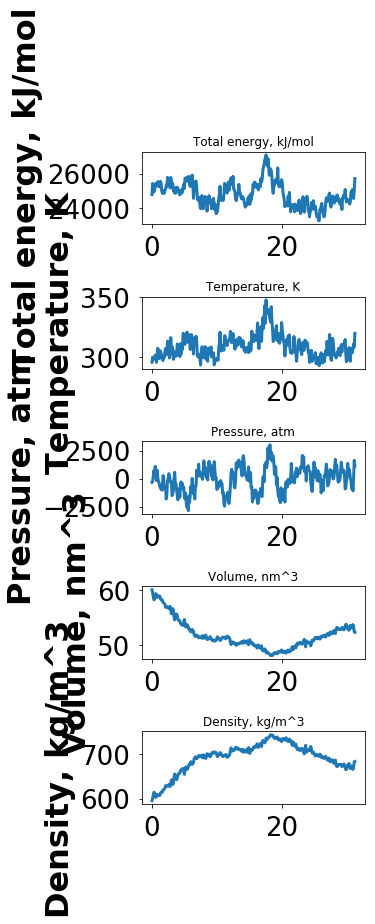

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('npt-prod-hexane.xvg', skiprows=27)

fig, ax = plt.subplots(5, 1)

properties = ['Total energy, kJ/mol', 'Temperature, K', 'Pressure, atm', 'Volume, nm^3', 'Density, kg/m^3']

for i, sub_ax in enumerate(ax):
    sub_ax.plot(data[:, 0], data[:, i + 1])
    sub_ax.set_title(properties[i])
    sub_ax.set_ylabel(properties[i])
    
fig.subplots_adjust(hspace=1.0)
fig.set_size_inches(4, 12)
plt.show()